# Connected component labeling in tiles
Labeling objects in tiles is a challenging task. If this step cannot be circumvented, the [dask-image](http://image.dask.org/en/latest/) offers the right functionality to retrieve label images with labels crossing multiple tiles. 

In [1]:
import numpy as np
import dask
import dask.array as da
from skimage.data import cells3d
from skimage.io import imread
from skimage.measure import label as skimage_label
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from dask_image.ndmeasure import label as daskimage_label

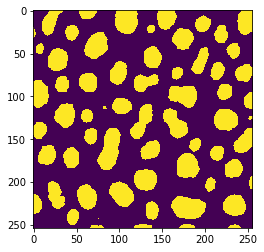

In [2]:
image = imread("../../data/blobs.tif") > 128
imshow(image)

In [3]:
tiles = da.from_array(image, chunks=(128, 128))
tiles

dask.array<array, shape=(254, 256), dtype=bool, chunksize=(128, 128), chunktype=numpy.ndarray>

We will use scikit-image function `label()` for processing our image.

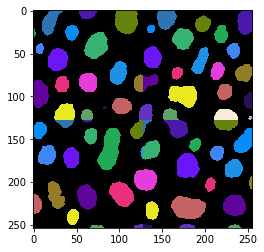

In [4]:
procedure = skimage_label

tile_map = da.map_blocks(procedure, tiles)

result = tile_map.compute()
imshow(result, labels=True)

In this image, we can already see that the result has artifacts at the tile borders in the horizontal and vertical image center. To further check the result, we will compute the connected component labeling of the image without tiling.

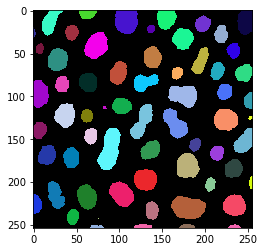

In [5]:
reference = skimage_label(image)

imshow(reference, labels=True)

Next, we can compare the maximum intensity in the label image to see if the total number of labels in these two images are equal. They are not:

In [6]:
result.max(), reference.max()

(20, 63)

By computing the standard deviation of the pixel intensity in the result image grouped by the reference labels, we can visualize which objects are not segmented correctly.

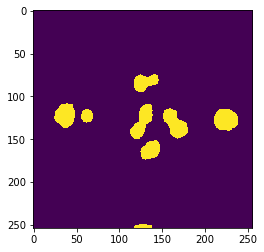

In [7]:
stddev_map = cle.standard_deviation_intensity_map(result, reference) > 0

imshow(stddev_map)

## Tiled connected component labeling using dask-image
The image processing library dask-image has a distributed version of connected component labeling available [dask_image.ndmeasure.label](http://image.dask.org/en/latest/dask_image.ndmeasure.html?highlight=label#dask_image.ndmeasure.label):

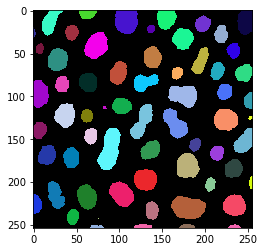

In [8]:
result_di, num_labels = daskimage_label(image)

imshow(result_di, labels=True)

Note that the result of this operation is a dask-array, and computing the maximum for example is not straightforward:

In [9]:
result_di.max(), reference.max()

(dask.array<amax-aggregate, shape=(), dtype=int32, chunksize=(), chunktype=numpy.ndarray>,
 63)

In [10]:
np.asarray(result_di).max(), reference.max()

(63, 63)